<div id="container" style="position:relative;">
<div style="float:left"><h2>  Waldman Diamond Canada Customers Clusterization Using K-means </h2></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://wdccanada.com/media/uploads/Original/logo.jpg" />
</div>
</div>

### About Waldman Diamond Canada
Waldman Diamond Canada (WDC) is a diamond wholesale company established in 2004 in Vancouver, Canada.

### Purpose of the classification
Despite the fact that the company has achieved success over their 14 years in the market, their prices are set without much knowledge about who their most valuable customers are, how to group them and set the best markup prices given the depth of their relationship.

The purpose of the clusterization is to help them to create a more straightforward strategy to set their markup prices.

### Clusterization Method
To build this clusterization, given the quantity of data available, I'm going to use the RFM analysis to establish the most valuable and consistent customers and after that, I'll use the K-means technic to build the clusters. 

Here's an explanation about the K-means method: _[Click Here](https://en.wikipedia.org/wiki/K-means_clustering)_

#### Importing the data sources

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Formatting the float numbers
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
#importing files
InvoiceData = pd.read_excel(r'C:\Users\Tarik Lauar\Dropbox\Personal Tarik\01 - Documentos\DataScience\BrainStation\Project\Invoice Detail report.xlsx',parse_dates=[1])

In [4]:
MasterList = pd.read_excel(r'C:\Users\Tarik Lauar\Dropbox\Personal Tarik\01 - Documentos\DataScience\BrainStation\Project\Master Client List.xlsx', index_col = [0])

In [5]:
ActiveCustomers = pd.read_excel(r'C:\Users\Tarik Lauar\Dropbox\Personal Tarik\01 - Documentos\DataScience\BrainStation\Project\ActiveCustomers.xlsx', index_col = [0])

### Data Cleansing

### Invoice dataset
Business Rules applied:
1. Removing the _Shipping_ , _Certificates_ & _Certification_ and _Setting & Finishing_ items

In [6]:
# Marking the Shipping, Certificates and Certification, Setting & Finishing items
InvoiceData['ExcludeFlag_Desc'] = InvoiceData['Description'].apply(lambda x: 1 if 'Shipping' in x or 'ertificat' in x or 'Setting & Finishing' in x else 0)

2. Removing the returned sales _(Sum of all items equal 0)_

In [7]:
# Marking the returned orders
ReturnedList = []

# Create a dataframe with the orders with the total equal zero
SumZero = InvoiceData.groupby('TransNum').agg({'Total': np.sum})
ReturnedList = list(SumZero[(SumZero['Total'] == 0)].index)

ToValid = []

ToValid = InvoiceData['TransNum'].tolist()

ExcludeFlag_Ret = []

for item in ToValid:
    if item in ReturnedList:
        ExcludeFlag_Ret.append(1)
    else:
        ExcludeFlag_Ret.append(0)
        
# Append the list of orders to be removed
InvoiceData['ExcludeFlag_Ret'] = ExcludeFlag_Ret

3. Removing sales from Nov'19 onward _(This month is incomplete)_

In [8]:
InvoiceDataClean = InvoiceData[(InvoiceData['ExcludeFlag_Desc']==0) & (InvoiceData['ExcludeFlag_Ret']==0) & (InvoiceData['Date']<'2019-11-01')]

4. Removing unnecessary columns

In [9]:
InvoiceDataClean.drop(['Division','Invoice Total','Payments','Balance','Currency','Invoice Status','Sales Person','Aging','Processed By','StockNum','Qty','Weight','Description','R_Pc','Unit','TaxAmt','LineNum','ExcludeFlag_Desc','ExcludeFlag_Ret'], axis=1, inplace=True)

C:\Users\Tarik Lauar\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Client Master List dataset
Business Rules applied:
1. Removing the customers with _CustomerType_ equals to _CLOSED_ and the "One Time" customers.

In [10]:
MasterListClean = MasterList[(MasterList['CustomerType'] != 'CLOSED') & 
                             (MasterList['CustomerName'] != 'Onetime BC') & 
                             (MasterList['CustomerName'] != 'Onetime AB') & (MasterList['CustomerName'] != 'Onetime ON') ]

### Data preparation

1. With the cleaned invoice dataset, create a dataframe with the sum of the sales, quantity of purchases and time in months since the last purchase to prepare the RFM analysis
2. Merging the auxiliary dataframes together
3. Merge the final auxiliary dataframe with the Customers dataset
4. Analysing the final dataset, adjusting NaN's and start the analysis and modeling.

#### Auxiliary dataframe with the sum of sales and quantity of purchases (Monetary and Frequency).

In [11]:
# Creating the monetary and the frequency
MonetFreq = InvoiceDataClean.groupby('ClientID').agg({'Total': np.sum, 'TransNum' : pd.Series.nunique})

MonetFreq.rename(columns={"Total": "Monetary", "TransNum": "Frequency"}, inplace=True)

#### Auxiliary dataframe with the time in months since the last purchase (Recency)

In [12]:
# 1 - Discovering the last purchase of each customer

Recency = InvoiceDataClean.sort_values('Date', ascending=False).groupby('ClientID')['Date'].apply(list).apply(pd.Series).reset_index()
# truncate and rename columns
Recency = Recency[['ClientID', 0]]

Recency.columns = ['ClientID', 'LastPurchase']

Recency.set_index('ClientID', inplace=True)

#Calculating the quantity of months since the last purchase

from datetime import datetime
from dateutil import relativedelta

Lastdate = '2019-11-30'

LastPurchaseList = Recency['LastPurchase'].tolist()

RecencyList = []

for item in LastPurchaseList:
    RecencyList.append(round(abs(item - datetime.strptime(Lastdate,"%Y-%m-%d")).days/30,0))
    
Recency['Recency'] = RecencyList

Recency = Recency.drop(['LastPurchase'], axis=1)

#### Merging the auxiliary dataframes

In [13]:
# Merge the information together
RFM = pd.merge(MonetFreq,Recency, on='ClientID')

#### Merging the final auxiliary dataframe with the Customer List

In [14]:
# Merge the RFM dataframe with the Master List
CustomersRFM = pd.merge(MasterListClean,RFM, on='ClientID', how='left')

#### Analysing the final dataset, adjusting NaN's and start the analysis and modeling.

In [15]:
# Treating NaN
# Replace NAN in Monetary and Frequency for 0
CustomersRFM['Monetary'].fillna(0, inplace=True)
CustomersRFM['Frequency'].fillna(-15, inplace=True)
# Replace NAN in Recency for 25
CustomersRFM['Recency'].fillna(25, inplace=True)

#### Analyzing the distributions

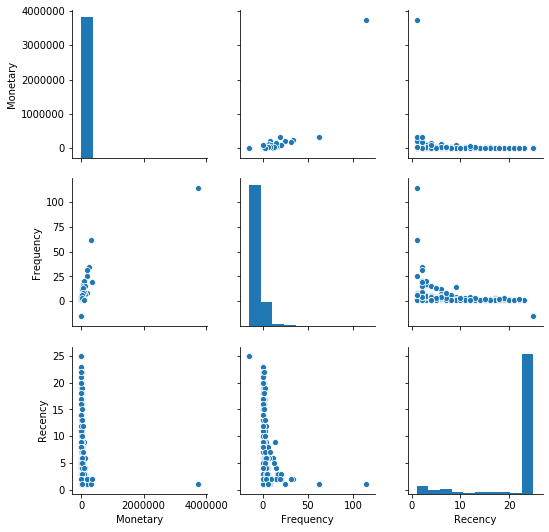

In [16]:
from seaborn import pairplot, heatmap
sns.pairplot(CustomersRFM, diag_kind='auto')

According to the distributions, it seems that there is a customer who is an outlier. I'll check the top 10 customers by monetary value to discover who is this customer

Text(0.5, 1.0, 'Top 10 customers by monetary amount')

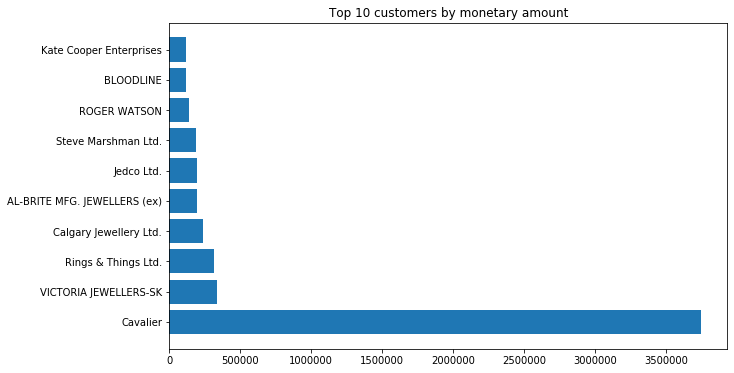

In [17]:
#Disconvering the outlier
CustomersRFM.sort_values(by=['Monetary'], ascending = False, inplace = True)

Top10Monetary = CustomersRFM.head(10)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(Top10Monetary['CustomerName'], Top10Monetary['Monetary'])
plt.title('Top 10 customers by monetary amount')

The customer Cavalier has more than $3.5M CAD in sales. It seems to be a class on its own. Let's remove it and see how the distribution looks like.

In [18]:
# Removing the first oulier
Aux2 = CustomersRFM[(CustomersRFM['CustomerName'] != 'Cavalier')]

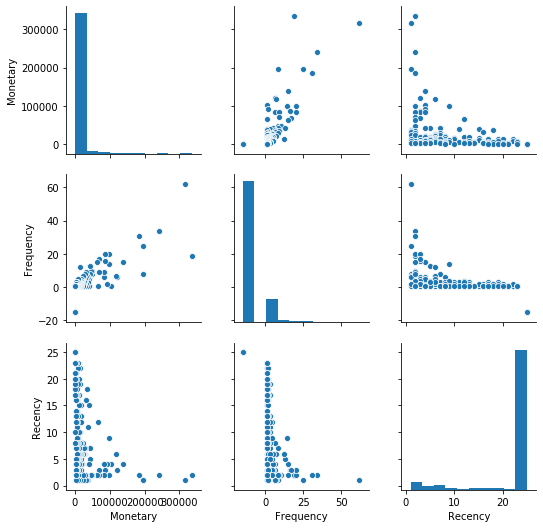

In [19]:
sns.pairplot(Aux2, diag_kind='auto')

It seems that we still have some customers with way more purchases than the rest and a lot of them with no transactions. Before removing the ones without purchases, let's see who are the other customers that seem to be big accounts.

C:\Users\Tarik Lauar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Top 20 customers by monetary amount')

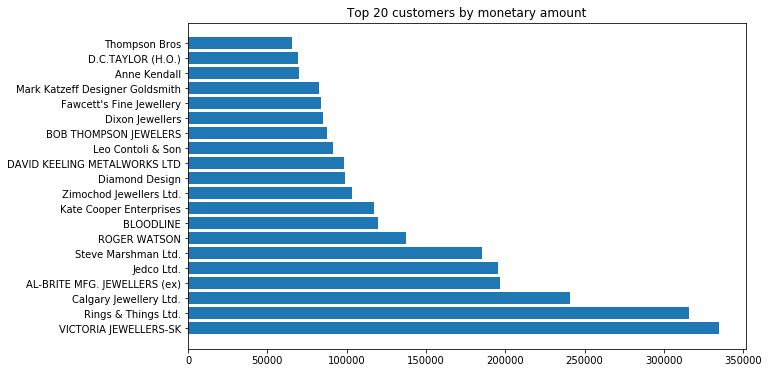

In [20]:
Aux2.sort_values(by=['Monetary'], ascending = False, inplace = True)

Top10Monetary2 = Aux2.head(20)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(Top10Monetary2['CustomerName'], Top10Monetary2['Monetary'])
plt.title('Top 20 customers by monetary amount')

The customers above $150k seem to be skewing the distribution. Let's remove them and also the customers without any purchases, and analyze the distributions again.

In [21]:
Aux3 = Aux2[(Aux2['Monetary'] > 0) & (Aux2['Monetary'] < 150000)]

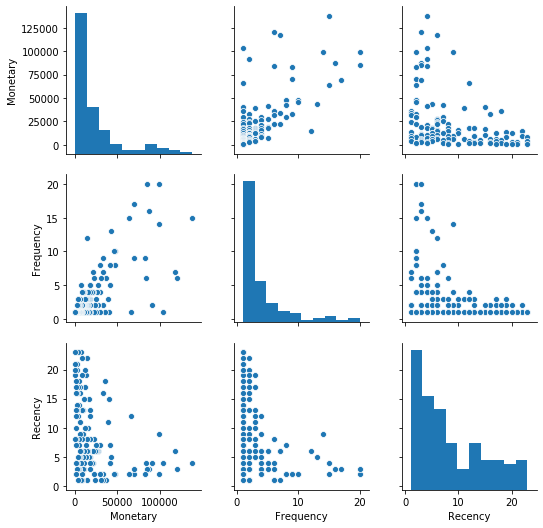

In [22]:
sns.pairplot(Aux3, diag_kind='auto')

### Creating the clusters using the K-means method

1- Scaling the data to fit variables with different units

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# scale the data
rfm_log = Aux3[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# transform into a dataframe
rfm_scaled = pd.DataFrame(rfm_scaled, index = Aux3.index, columns = rfm_log.columns)

Creating an elbow chart to determine the best number of clusters

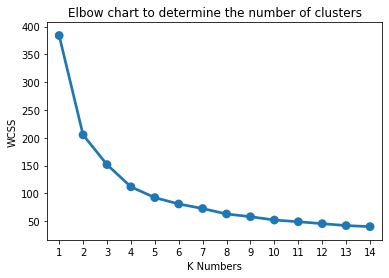

In [24]:
# the Elbow method
wcss = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 120000, random_state = 12345)
    kmeans.fit(rfm_scaled)
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.title('Elbow chart to determine the number of clusters')
plt.show()

According to the elbow chart above, the best number of clusters would be 3

In [25]:
# clustering
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 120000, random_state = 12345)
clus.fit(rfm_scaled)
# Assign the clusters to datamart
Aux3['K_Cluster'] = clus.labels_

C:\Users\Tarik Lauar\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [26]:
# assign cluster column 
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled.reset_index(inplace = True)
# melt the dataframe
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['ClientID', 'K_Cluster'], var_name = 'Metrics', value_name = 'Value')

Text(0.5, 1.0, 'K-means classification')

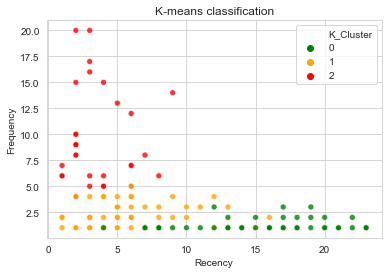

In [27]:
sns.set_style('whitegrid')
sns.scatterplot(data=Aux3, x='Recency', y='Frequency', palette=['green','orange','red'], 
                hue='K_Cluster', alpha=0.8)
plt.title('K-means classification')

According to the plot above, the model created 3 clusters that we can name as:
1. Higly engaged (Cluster 0) --> High frequency and High recency
2. Moderately engaged (Cluster 2) --> Low frequency and High recency
3. Moderately disengaged (Cluster 1) --> Low frequency and Low recency

Now I'm going to re-insert the removed customers and create a name for the clusters

In [28]:
Aux4 = Aux3['K_Cluster']
CustomersRFMFinal = pd.merge(CustomersRFM,Aux4, on='ClientID', how='left')

ListMonet = CustomersRFMFinal['Monetary'].tolist()
ListKClust = CustomersRFMFinal['K_Cluster'].tolist()
ListClustClass = []

for i in range(len(ListMonet)):
    if ListMonet[i] >= 150000:
        ListClustClass.append('0-Key Accounts')
    elif ListKClust[i] == 1:
        ListClustClass.append('2-Moderately Engaged')
    elif ListKClust[i] == 2:
        ListClustClass.append('1-Highly Engaged')
    elif ListKClust[i] == 0:
        ListClustClass.append('3-Moderately Disengaged')
    else:
        ListClustClass.append('4-Disengaged')
        
CustomersRFMFinal['ClusterClassification'] = ListClustClass

CustomersRFMFinal.sort_values(by=['ClusterClassification'], inplace = True)

Plotting the results to see how the customers are grouped

Text(0.5, 1.0, 'WDC Customers Cluster distribution')

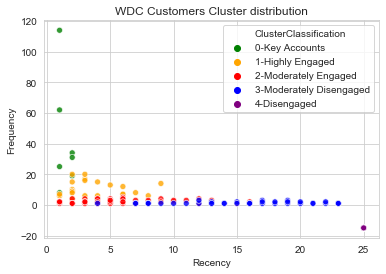

In [29]:
sns.set_style('whitegrid')
sns.scatterplot(data=CustomersRFMFinal, x='Recency', y='Frequency', palette=['green','orange','red','blue','purple'], 
                hue='ClusterClassification', alpha=0.8)
plt.title('WDC Customers Cluster distribution')

These are the quantity of customers for each group:

In [30]:
CustomersRFMFinal.groupby('ClusterClassification').size()

ClusterClassification
0-Key Accounts               7
1-Highly Engaged            30
2-Moderately Engaged        56
3-Moderately Disengaged     42
4-Disengaged               721
dtype: int64

After the analysis, 5 clusters were created:
1. Key Accounts (Outliers customers - Discarded for the modeling purpose)
2. Highly engaged
3. Moderately engaged
4. Moderately disengaged
5. Disengaged (no transactions during the period - Discarded for the modeling purpose)

WDC leadership will set up their pricing strategy based on this model later.